## Model Selection

Import libraries and load the current modeling data for `AmazonReviews`

In [1]:
from nltk.corpus import words, stopwords
from nltk import SnowballStemmer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from skopt import BayesSearchCV

# latest sklearn issue
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')
        
from skopt.space import Real, Integer, Categorical

from xgboost import XGBClassifier

from sklearn import metrics


import numpy as np
import pandas as pd
import dill

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

stemmer = SnowballStemmer('english')

def english_corpus(doc, tkpat=re.compile('\\b[a-z][a-z]+\\b')):
    return [stemmer.stem(w) for w in tkpat.findall(doc)]

MODELING_PATH = '../data/modeling/'
PATH = '../data/amazon_reviews_us_Toys_v1_00.tsv'

In [2]:
# save progress
def save(obj, obj_name):
    f = MODELING_PATH + obj_name
    dill.dump(obj, open(f, 'wb'))

def load(obj_name):
    f = MODELING_PATH + obj_name
    return dill.load(open(f, 'rb'))

In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
from AmazonReviews import AmazonReviews

ar = AmazonReviews()

In [7]:
ar.load_data(PATH)
ar.calc_trend_score()
ar.create_observations()
ar.create_train_test_split()

Read from pickle...


## Setup

Create inital dictionaries of standard parameters to be utilized in the different algorithms. 

In [4]:
skf = StratifiedKFold(n_splits = 5, random_state=ar.RANDOM_STATE) # 80/20 split

In [5]:
stop_words = load('stop_words.pkl')
count_vectorizer_parameters = {
    'stop_words': stop_words, 
    'tokenizer': english_corpus, 
    'min_df': 100,
    'max_df': 0.2,
    'ngram_range': (1,2)
}

In [6]:
lda_parameters = {
    'n_components': 5,
    'learning_decay': 0.6,
    'batch_size': 256,
    'learning_offset': 1024,
    'learning_method': 'online',
    'topic_word_prior': 0.005,
    'n_jobs': -1,
    'random_state': ar.RANDOM_STATE
}

xgb_parameters = {
    'random_state': ar.RANDOM_STATE,
    'n_jobs': -1,
    'objective': 'binary:logistic'
}

bayes_cv_parameters = {
    'n_iter': 10,
    'scoring': 'roc_auc',
    'n_jobs': -1,
    'cv': skf,
    'random_state': ar.RANDOM_STATE,
    'verbose': 2
}

## 5 topic baseline model

Create the document transformation pipeline.

In [10]:
doc_pipeline = Pipeline(
    [
        ('cnt_vector', CountVectorizer(**count_vectorizer_parameters)),
        ('lda', LatentDirichletAllocation(**lda_parameters)),
        ('log_tansform', FunctionTransformer(np.log))
    ]
)

Transform `X_train`.

In [11]:
ar.X_train.head()

43652     this is great for your hair  and it chainges c...
110963    Not worth   bucks!!!!! This toy feels really c...
148853    I saw this same size at Walmart for $ . .  Grr...
193505    There is nothing wrong with the quality of the...
141197    I purchased this boat as a RTR boat it ran awe...
Name: review_body, dtype: object

In [12]:
X_train_transformed = doc_pipeline.fit_transform(ar.X_train)
pd.DataFrame(X_train_transformed).head()

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abbiat', 'abov', 'ag', 'ahogi', 'alguna', 'alguno', 'ame', 'anch', 'ani', 'ant', 'anum', 'aquel', 'ata', 'atar', 'aurion', 'auron', 'avai', 'avess', 'avest', 'avet', 'avev', 'avion', 'avon', 'avrebb', 'avrest', 'avret', 'ayon', 'baiknya', 'becaus', 'befor', 'begg', 'benn', 'beraw', 'berkali', 'catr', 'dag', 'dasselb', 'deir', 'depoi', 'dera', 'derselb', 'desd', 'despr', 'dett', 'dieselb', 'diss', 'diy', 'doe', 'dond', 'durant', 'dure', 'ebb', 'egi', 'egyr', 'ell', 'ello', 'emm', 'entr', 'erai', 'erav', 'ere', 'err', 'ess', 'estabai', 'estamo', 'estaremo', 'estejamo', 'estemo', 'estev', 'estiv', 'estivemo', 'estivermo', 'estivess', 'estuv', 'estuvierai', 'estuvies', 'estuviesei', 'estuvimo', 'estuvist', 'estuvistei', 'etwa', 'eur', 'euss', 'eussion', 'facciat', 'facess', 'facest', 'facev', 'f

,0,1,2,3,4
0,-1.163406,-1.502369,-2.277449,-3.799966,-1.078631
1,-3.392146,-0.661416,-5.518949,-5.505256,-0.816066
2,-3.552560,-0.661913,-3.555348,-0.921618,-3.539122
3,-0.740555,-1.036868,-2.382708,-6.072368,-2.603940
4,-4.933263,-0.392475,-1.442277,-2.606668,-4.927490


In [ ]:
save(X_train_transformed, 'X_train_transformed.pkl')

In [13]:
save(doc_pipeline, 'doc_5t_transformer.pkl')

Create the parameters to perform `BayesSeachCV` over.

In [7]:
xgb_search_params = {
    'max_depth': Integer(2, 6),
    'learning_rate': Real(0, 0.5),
    'n_estimators': Integer(100, 1000),
    'gamma': Real(0, 0.5)
}

Fit the baseline model.

In [9]:
!ls ../data/modeling/ -al

total 110708
drwxrwxr-x 2 ubuntu ubuntu     4096 Nov 12 20:59 .
drwxrwxr-x 3 ubuntu ubuntu     4096 Nov 12 04:06 ..
-rw-rw-r-- 1 ubuntu ubuntu   782046 Nov 12 12:24 baeline_estimator.pkl
-rw-rw-r-- 1 ubuntu ubuntu     4821 Nov 12 12:24 baseline_cv_results.pkl
-rw-r--r-- 1 ubuntu ubuntu  6336163 Nov 12 04:04 baseline_X_train
-rw-rw-r-- 1 ubuntu ubuntu  1357084 Nov 12 12:24 base_SMOTE_search.pkl
-rw-rw-r-- 1 ubuntu ubuntu     1042 Nov 12 20:59 results_df.pkl
-rw-rw-r-- 1 ubuntu ubuntu  1342096 Nov 12 13:15 SMOTE_10t_search.pkl
-rw-rw-r-- 1 ubuntu ubuntu    71926 Nov 12 12:24 stop_words.pkl
-rw-rw-r-- 1 ubuntu ubuntu        0 Nov 12 20:59 test.pkl
-rw-rw-r-- 1 ubuntu ubuntu  4224161 Nov 12 20:59 X_test_SMOTE_10_transformed.pkl
-rw-rw-r-- 1 ubuntu ubuntu 12538323 Nov 12 12:24 X_train_baseline_SMOTE.pkl
-rw-rw-r-- 1 ubuntu ubuntu 31648447 Nov 12 12:24 X_train.pkl
-rw-rw-r-- 1 ubuntu ubuntu 25076483 Nov 12 12:39 X_train_SMOTE_10t.pkl
-rw-rw-r-- 1 ubuntu ubuntu 12672163 Nov 12 12:39 X_train_t

In [10]:
X_train_transformed = load('X_train_transformed.pkl')
ar.y_train = load('y_train.pkl')

In [13]:
xgb = XGBClassifier(**xgb_parameters)

bayes_search = BayesSearchCV(xgb, xgb_search_params, **bayes_cv_parameters)

bayes_search.fit(X_train_transformed, ar.y_train)
save(bayes_search, 'baseline_search.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.4s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   56.0s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.2s remaining:   31.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.1s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   60.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   60.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   34.8s remaining:   52.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.6s finished


In [14]:
y_pred = bayes_search.best_estimator_.predict_proba(X_train_transformed)[:,1]

ar.log_score(ar.y_train, y_pred, '5_topic')
save(ar.results, 'results_df.pkl')
save(ar.y_scores, 'y_scores.pkl')
ar.results

,AUC,Accuracy,F1,Precision,Recall
5_topic,0.910513,0.989514,0.014243,1.0,0.007173


Pretty high AUC, but the confusion matrix metrics are most likely skewed with the default cutoff of 50%.

## 5-topic SMOTE model

Let's now try up-sampling to see if this can improve the classification.

In [11]:
smote_pipeline = imbPipeline(
    [
        ('sm', SMOTE(random_state=ar.RANDOM_STATE, n_jobs=-1)),
        ('xgb', XGBClassifier(**xgb_parameters))
    ],
    memory = '../data/transform_memory/'
)

xgb_smote_search_params = {
    'xgb__max_depth': Integer(2, 6),
    'xgb__learning_rate': Real(0, 0.5),
    'xgb__n_estimators': Integer(100, 1000),
    'xgb__gamma': Real(0, 0.5)
}


In [16]:
bayes_search = BayesSearchCV(smote_pipeline, xgb_smote_search_params, **bayes_cv_parameters)

bayes_search.fit(X_train_transformed, ar.y_train)
save(bayes_search, 'SMOTE_5t_search.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   37.0s remaining:   55.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [17]:
y_pred = bayes_search.best_estimator_.predict_proba(X_train_transformed)[:,1]

In [18]:
ar.log_score(ar.y_train, y_pred, 'SMOTE_5t')
ar.results

,AUC,Accuracy,F1,Precision,Recall
5_topic,0.910513,0.989514,0.014243,1.00000,0.007173
SMOTE_5t,0.797784,0.739470,0.054180,0.02817,0.706515


In [19]:
save(ar.results, 'results_df.pkl')
save(ar.y_scores, 'y_scores.pkl')

Applying SMOTE decreased the AUC from **0.91** to **0.79**.

5_topic
SMOTE_5t


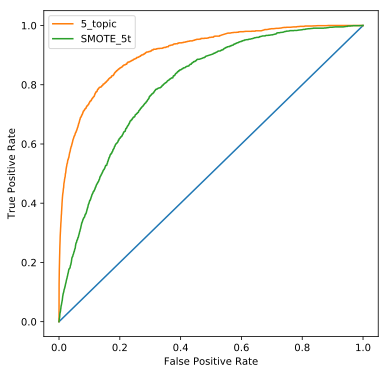

In [20]:
ar.y_train = load('y_train.pkl')
ar.plot_roc_curve();

In [21]:
pd.DataFrame(bayes_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,122.933320,1.193159,0.655716,0.205052,0.363863,6,384,"{'xgb__gamma': 0.20505197942665693, 'xgb__lear...",1,0.675278,0.646144,0.672189,0.627126,0.657841,4.880232,0.152969,0.017706
1,139.996067,1.294779,0.678534,0.418694,0.441658,3,956,"{'xgb__gamma': 0.4186941777766422, 'xgb__learn...",1,0.673510,0.686828,0.697366,0.652392,0.682576,7.822521,0.052503,0.015155
2,46.485036,0.398324,0.712347,0.222416,0.459361,2,490,"{'xgb__gamma': 0.22241625615057592, 'xgb__lear...",1,0.696173,0.725059,0.732692,0.695067,0.712742,3.511774,0.005068,0.015072
3,161.188852,1.491554,0.702998,0.406198,0.085936,4,822,"{'xgb__gamma': 0.4061979941786817, 'xgb__learn...",1,0.691615,0.711735,0.718971,0.685216,0.707451,8.484046,0.042646,0.012626
4,144.588635,1.318725,0.683669,0.399777,0.219015,4,744,"{'xgb__gamma': 0.39977672080358656, 'xgb__lear...",1,0.685115,0.683236,0.701308,0.663130,0.685557,5.180795,0.018610,0.012156
5,39.317711,0.319147,0.702457,0.367014,0.469685,3,270,"{'xgb__gamma': 0.3670140089927842, 'xgb__learn...",1,0.679684,0.719155,0.720929,0.681620,0.710896,2.442707,0.046972,0.018133
6,127.560940,1.190942,0.685211,0.308540,0.387682,3,887,"{'xgb__gamma': 0.30853967925115816, 'xgb__lear...",1,0.681127,0.689976,0.706768,0.661211,0.686972,6.815955,0.008978,0.014719
7,169.848792,1.618786,0.662848,0.271702,0.460005,4,854,"{'xgb__gamma': 0.2717015338451563, 'xgb__learn...",1,0.668710,0.659701,0.681210,0.634843,0.669777,7.675517,0.242879,0.015580
8,119.182855,1.157184,0.665885,0.477739,0.350311,5,474,"{'xgb__gamma': 0.47773899315496415, 'xgb__lear...",1,0.666536,0.666124,0.685190,0.638226,0.673346,7.582207,0.032357,0.015452
9,81.965714,0.780865,0.666905,0.001815,0.408915,5,329,"{'xgb__gamma': 0.0018151536273716133, 'xgb__le...",1,0.671315,0.669132,0.678692,0.646385,0.669002,4.979502,0.008296,0.010852


## 10-topic Model

Let's now see the impact of increasing the LDA topics from 5 to 10, but not applying SMOTE.

In [22]:
ar.X_train = load('X_train.pkl')
ar.y_train = load('y_train.pkl')

In [23]:
lda_parameters['n_components'] = 10
# count_vectorizer_parameters['stop_words'] = load('stop_words.pkl')

doc_pipeline = Pipeline(
    [
        ('cnt_vector', CountVectorizer(**count_vectorizer_parameters)),
        ('lda', LatentDirichletAllocation(**lda_parameters)),
        ('log_tansform', FunctionTransformer(np.log))
    ]
)

In [24]:
X_train_transformed = doc_pipeline.fit_transform(ar.X_train)
save(X_train_transformed, 'X_train_transformed_10_topics.pkl')

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abbiat', 'abov', 'ag', 'ahogi', 'alguna', 'alguno', 'ame', 'anch', 'ani', 'ant', 'anum', 'aquel', 'ata', 'atar', 'aurion', 'auron', 'avai', 'avess', 'avest', 'avet', 'avev', 'avion', 'avon', 'avrebb', 'avrest', 'avret', 'ayon', 'baiknya', 'becaus', 'befor', 'begg', 'benn', 'beraw', 'berkali', 'catr', 'dag', 'dasselb', 'deir', 'depoi', 'dera', 'derselb', 'desd', 'despr', 'dett', 'dieselb', 'diss', 'diy', 'doe', 'dond', 'durant', 'dure', 'ebb', 'egi', 'egyr', 'ell', 'ello', 'emm', 'entr', 'erai', 'erav', 'ere', 'err', 'ess', 'estabai', 'estamo', 'estaremo', 'estejamo', 'estemo', 'estev', 'estiv', 'estivemo', 'estivermo', 'estivess', 'estuv', 'estuvierai', 'estuvies', 'estuviesei', 'estuvimo', 'estuvist', 'estuvistei', 'etwa', 'eur', 'euss', 'eussion', 'facciat', 'faces

In [25]:
bayes_search = BayesSearchCV(xgb, xgb_search_params, **bayes_cv_parameters)
bayes_search.fit(X_train_transformed, ar.y_train)
save(bayes_search, '10t_search.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.7s remaining:   50.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.4s remaining:   41.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   56.3s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [26]:
y_probs = bayes_search.best_estimator_.predict_proba(X_train_transformed)[:,1]

In [30]:
ar.log_score(ar.y_train, y_probs, '10_topic')

In [33]:
ar.results

,AUC,Accuracy,F1,Precision,Recall
5_topic,0.910513,0.989514,0.014243,1.00000,0.007173
SMOTE_5t,0.797784,0.739470,0.054180,0.02817,0.706515
10_topic,0.924817,0.989545,0.020118,1.00000,0.010161


5_topic
SMOTE_5t
SMOTE_10t


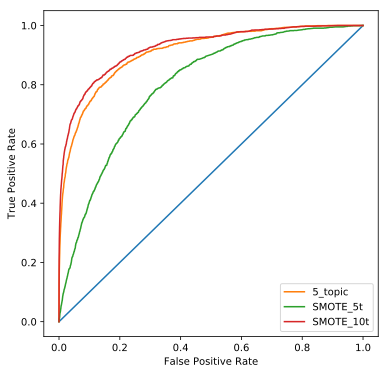

In [29]:
ar.plot_roc_curve()

In [35]:
np.abs(0.910513 - 0.924817)/ 0.910513

0.015709825120563882

The AUC improved further with the utilizing 10 topics from **0.91** to **0.92**, which is about 1.5% increase.

In [45]:
!ls ../data/modeling/ -lat

total 112392
-rw-rw-r-- 1 ubuntu ubuntu  1901262 Nov 12 22:32 y_scores.pkl
-rw-rw-r-- 1 ubuntu ubuntu     1126 Nov 12 22:32 results_df.pkl
-rw-rw-r-- 1 ubuntu ubuntu   802667 Nov 12 22:11 10t_search.pkl
drwxrwxr-x 2 ubuntu ubuntu     4096 Nov 12 22:11 .
-rw-rw-r-- 1 ubuntu ubuntu 12672269 Nov 12 21:55 X_train_transformed_10_topics.pkl
-rw-rw-r-- 1 ubuntu ubuntu   315706 Nov 12 21:45 SMOTE_5t_search.pkl
drwxrwxr-x 4 ubuntu ubuntu     4096 Nov 12 21:24 ..
-rw-rw-r-- 1 ubuntu ubuntu   809475 Nov 12 21:12 baseline_search.pkl
-rw-rw-r-- 1 ubuntu ubuntu        0 Nov 12 20:59 test.pkl
-rw-rw-r-- 1 ubuntu ubuntu  6336269 Nov 12 20:59 X_train_transformed.pkl
-rw-rw-r-- 1 ubuntu ubuntu  4224161 Nov 12 20:59 X_test_SMOTE_10_transformed.pkl
-rw-rw-r-- 1 ubuntu ubuntu  1342096 Nov 12 13:15 SMOTE_10t_search.pkl
-rw-rw-r-- 1 ubuntu ubuntu  2507793 Nov 12 12:39 y_train_SMOTE_10t.pkl
-rw-rw-r-- 1 ubuntu ubuntu 25076483 Nov 12 12:39 X_train_SMOTE_10t.pkl
-rw-rw-r-- 1 ubuntu ubuntu  2507793 Nov 12 12:24 

In [12]:
b_search_5_topic = load('baseline_search.pkl')
b_search_smote_5_topic = load('SMOTE_5t_search.pkl')
b_search_10_topic = load('10t_search.pkl')

In [40]:
print(b_search_5_topic.best_score_, b_search_smote_5_topic.best_score_, b_search_10_topic.best_score_)

0.7112579818344774 0.71234656407633 0.7107978637308618


In [41]:
ar.results

,AUC,Accuracy,F1,Precision,Recall
5_topic,0.910513,0.989514,0.014243,1.00000,0.007173
SMOTE_5t,0.797784,0.739470,0.054180,0.02817,0.706515
10_topic,0.924817,0.989545,0.020118,1.00000,0.010161


Let's try SMOTE plus Tomek links to see if this can improve upon the classification.

## 5 Topic SMOTE + Tomek

In [8]:
smote_pipeline = imbPipeline(
    [
        ('sm', SMOTETomek(random_state=ar.RANDOM_STATE)),
        ('xgb', XGBClassifier(**xgb_parameters))
    ],
    memory = '../data/transform_memory/'
)

xgb_smote_search_params = {
    'xgb__max_depth': Integer(2, 6),
    'xgb__learning_rate': Real(0, 0.5),
    'xgb__n_estimators': Integer(100, 1000),
    'xgb__gamma': Real(0, 0.5)
}


In [9]:
X_train_transformed = load('X_train_transformed.pkl')
ar.y_train = load('y_train.pkl')

In [13]:
bayes_search = BayesSearchCV(smote_pipeline, xgb_smote_search_params, **bayes_cv_parameters)

bayes_search.fit(X_train_transformed, ar.y_train)
save(bayes_search, 'SMOTE_Tomek_5t_search.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   38.9s remaining:   58.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [19]:
y_pred = bayes_search.best_estimator_.predict_proba(X_train_transformed)[:,1]
ar.log_score(ar.y_train, y_pred, 'SMOTE_Tomek_5t')

In [15]:
ar.results = load('results_df.pkl')
ar.y_scores = load('y_scores.pkl')

In [20]:
ar.results

,AUC,Accuracy,F1,Precision,Recall
5_topic,0.910513,0.989514,0.014243,1.000000,0.007173
SMOTE_5t,0.797784,0.739470,0.054180,0.028170,0.706515
10_topic,0.924817,0.989545,0.020118,1.000000,0.010161
SMOTE_Tomek_5t,0.798006,0.738434,0.054884,0.028531,0.719068


In [8]:
b_search_5_topic = load('baseline_search.pkl')
b_search_smote_5_topic = load('SMOTE_5t_search.pkl')
b_search_10_topic = load('10t_search.pkl')
b_search_sm_tomek_5_topic = load ('SMOTE_Tomek_5t_search.pkl')

In [14]:
print(f'5 topic: {b_search_5_topic.best_score_:.3}\n', 
      f'5 topic SMOTE: {b_search_smote_5_topic.best_score_:.3}\n', 
      f'10 topic: {b_search_10_topic.best_score_:.3}\n', 
      f'5 topic SMOTE + Tomek: {b_search_sm_tomek_5_topic.best_score_:.3}\n')

5 topic: 0.711
 5 topic SMOTE: 0.712
 10 topic: 0.711
 5 topic SMOTE + Tomek: 0.716



Pretty similar results with a very slight increase. We will go with the SMOTE + 5 topic model as the selected model. The 5 topic model is less complex, and up-sampling with SMOTE makes sense with an imbalanced classification problem. 

Now the full training data set will be re-fitted and saved.

In [18]:
X_train_transformed = load('X_train_transformed.pkl')
ar.y_train = load('y_train.pkl')
X_train_transformed[:10]

array([[-1.17185721, -1.51945668, -2.25267629, -3.80308459, -1.06723341],
       [-3.38693294, -0.66370586, -5.51881697, -5.50528112, -0.81379633],
       [-3.55246054, -0.67577331, -3.55534806, -0.90409943, -3.53683442],
       [-0.7468804 , -1.06002239, -2.41431922, -6.07468138, -2.43063532],
       [-4.9328758 , -0.375     , -1.23450696, -4.92282832, -4.92699343],
       [-4.80594299, -4.80991647, -1.23336357, -0.37943659, -4.81433908],
       [-3.66461909, -0.05289608, -7.74898933, -7.75314393, -3.68700376],
       [-2.7080502 , -2.7080502 , -2.7080502 , -0.31755684, -2.6300523 ],
       [-4.30048866, -4.29518167, -0.75332016, -1.04321723, -1.89923029],
       [-2.29374991, -2.30047314, -0.5137134 , -2.30223737, -2.29663747]])

In [19]:
final_model = smote_pipeline.fit(X_train_transformed, ar.y_train)

In [21]:
metrics.roc_auc_score(ar.y_train, final_model.predict_proba(X_train_transformed)[:,1])

0.7638837050064682

In [22]:
save(final_model, 'final_model_smote_5t.pkl')

## Future Modeling
* Could look at the first week of reviews, essentially adding data to the model.
* tune k-neighbors
* BorderlineSMOTE
* SVMSmote

## Model ensembling

Let's fit 2 additional XGBoost trees and average the results together to see if we can get a further reduction in error.

In [8]:
ar.y_train = load('y_train.pkl')
X_train_transformed = load('X_train_transformed.pkl')

In [9]:
xgb_parameters['random_state'] = 1
bayes_cv_parameters['random_state'] = 1

smote_pipeline = imbPipeline(
    [
        ('sm', SMOTE(random_state=ar.RANDOM_STATE, n_jobs=-1)),
        ('xgb', XGBClassifier(**xgb_parameters))
    ],
    memory = '../data/transform_memory/'
)

xgb_smote_search_params = {
    'xgb__max_depth': Integer(2, 6),
    'xgb__learning_rate': Real(0, 0.5),
    'xgb__n_estimators': Integer(100, 1000),
    'xgb__gamma': Real(0, 0.5)
}

In [10]:
bayes_search = BayesSearchCV(smote_pipeline, xgb_smote_search_params, **bayes_cv_parameters)

bayes_search.fit(X_train_transformed, ar.y_train)
save(bayes_search, 'SMOTE_5t_search_rs_1.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.5s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   56.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   53.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.2min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [11]:
xgb_parameters['random_state'] = 2
bayes_cv_parameters['random_state'] = 2

smote_pipeline = imbPipeline(
    [
        ('sm', SMOTE(random_state=ar.RANDOM_STATE, n_jobs=-1)),
        ('xgb', XGBClassifier(**xgb_parameters))
    ],
    memory = '../data/transform_memory/'
)

xgb_smote_search_params = {
    'xgb__max_depth': Integer(2, 6),
    'xgb__learning_rate': Real(0, 0.5),
    'xgb__n_estimators': Integer(100, 1000),
    'xgb__gamma': Real(0, 0.5)
}

In [12]:
bayes_search = BayesSearchCV(smote_pipeline, xgb_smote_search_params, **bayes_cv_parameters)

bayes_search.fit(X_train_transformed, ar.y_train)
save(bayes_search, 'SMOTE_5t_search_rs_2.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


In [7]:
xgb_model_1 = load('SMOTE_5t_search.pkl')
xgb_model_2 = load('SMOTE_5t_search_rs_1.pkl')
xgb_model_3 = load('SMOTE_5t_search_rs_2.pkl')

In [8]:
# AUCs of the three estimators
print(xgb_model_1.best_score_, xgb_model_2.best_score_, xgb_model_3.best_score_)

0.71234656407633 0.7320745919743551 0.7257475897210353


In [9]:
vc = VotingClassifier(
    [
        ('xgb1', xgb_model_1.best_estimator_),
        ('xgb2', xgb_model_2.best_estimator_),
        ('xgb3', xgb_model_3.best_estimator_)
    ],
    voting = 'soft',
    n_jobs = -1
)

In [11]:
X_train_transformed = load('X_train_transformed.pkl')
ar.y_train = load('y_train.pkl')

In [12]:
vc.fit(X_train_transformed, ar.y_train)

VotingClassifier(estimators=[('xgb1', Pipeline(memory='../data/transform_memory/',
     steps=[('sm', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=-1,
   out_step='deprecated', random_state=42, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('xgb', XGBClassifier(ba...     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [13]:
y_probs = vc.predict_proba(X_train_transformed)[:,1]
metrics.roc_auc_score(ar.y_train, y_probs)

0.7978676346580182

In [14]:
y_probs = xgb_model_1.best_estimator_.predict_proba(X_train_transformed)[:,1]
metrics.roc_auc_score(ar.y_train, y_probs)

0.779633679193578

Ensembling 3 XGB trees with equal weights results in a better AUC compared to the single XGB tree. The ensemble model will be the final model.

In [15]:
save(vc, 'final_ensemble_5_topic.pkl')